In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
from scipy.spatial import distance_matrix, ConvexHull
import random
from random import choice
import os
from PIL import Image
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy.spatial.distance import pdist, squareform
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline
from collections import Counter
def remove_duplicates(segments):
    unique_segments = {}  # 创建一个空字典来存储唯一的线段

    for segment in segments:
        start, end = map(tuple, segment)  # 将数组转换为元组
        sorted_segment = tuple(sorted([start, end]))  # 对起点和终点进行排序

        if sorted_segment not in unique_segments:
            unique_segments[sorted_segment] = 1  # 如果这个线段还没有在字典中，则将其添加到字典中

    # 将字典的键（也就是唯一的线段）转换回数组
    return [list(map(list, segment)) for segment in unique_segments.keys()]
def remove_duplicates2(segments):
    unique_segments = {}  # 创建一个空字典来存储唯一的线段

    for segment in segments:
        segment_tuple = tuple(map(tuple, segment))  # 将数组转换为元组

        if segment_tuple not in unique_segments:
            unique_segments[segment_tuple] = 1  # 如果这个线段还没有在字典中，则将其添加到字典中

    # 将字典的键（也就是唯一的线段）转换回数组
    return [list(map(list, segment)) for segment in unique_segments.keys()]

# 修改plt默认图形大小
plt.rcParams['figure.figsize'] = [5, 5]
# 修改默认字体大小
plt.rcParams['font.size'] = 12
# 修改默认坐标轴标签的字体
plt.rcParams['axes.labelsize'] = 10


In [2]:
#调参cell
#调整角点识别参数
def gfttp(paramter1, paramter2, paramter3, paramter4, paramter5, paramter6):
    print('角点识别')
    print(f'maxCorners要检测的最大角点数目。如果超过此数目，将返回最强的角点: {paramter1}')
    print(f'qualityLevel角点的质量水平阈值。范围是0到1之间，表示角点质量的最小阈值: {paramter2}')
    print(f'minDistance两个角点之间的最小欧几里德距离。如果两个角点的距离小于此值，则只有其中一个会被保留: {paramter3}')
    print(f'blockSize：角点检测时的窗口大小。这个参数影响角点检测的精度: {paramter4}')
    print(f'useHarrisDetector一个布尔值，如果为True，则使用Harris角点检测器，如果为False，则使用Shi-Tomasi角点检测器: {paramter5}')
    print(f'k：Harris角点检测器的自由参数k。它影响角点响应函数的灵敏度，一般是0.04，减小能使检测器更灵敏: {paramter6} ')
    return paramter1, paramter2, paramter3, paramter4, paramter5, paramter6
interactive_plot = interactive(gfttp, paramter1=(0,500,1), 
                               paramter2=(0.000,0.100,0.001),
                               paramter3=(1,50,1), 
                               paramter4=(1,10,1),
                               paramter5=(0,1,1),
                               paramter6=(0.00,0.10,0.01))
interactive_plot.children[0].value = 300
interactive_plot.children[1].value = 0.01
interactive_plot.children[2].value = 15
interactive_plot.children[3].value = 5
interactive_plot.children[4].value = 0
interactive_plot.children[5].value = 0.02
display(interactive_plot)


interactive(children=(IntSlider(value=300, description='paramter1', max=500), FloatSlider(value=0.01, descript…

In [3]:
def find_matching_corners_connection(lines, corners, r):
    connects = []
    for line in lines:
        pt1, pt2 = line
        distances_to_pt1 = np.sqrt(np.sum((corners - pt1)**2, axis=1))
        distances_to_pt2 = np.sqrt(np.sum((corners - pt2)**2, axis=1))
        corner1 = corners[np.argmin(distances_to_pt1)]
        corner2 = corners[np.argmin(distances_to_pt2)]
        if np.linalg.norm(corner1 - pt1) < r and np.linalg.norm(corner2 - pt2) < r:
            connects.append(tuple(sorted([tuple(corner1), tuple(corner2)])))
    # remove duplicates
    connects = [list(item) for item in set(connects)]
    return np.array(connects)

corners number 185 corners shape (185, 2)
lsd line number 574 lsd line shape (574, 1, 4)
connects number 366 connects shape (366, 2, 2)


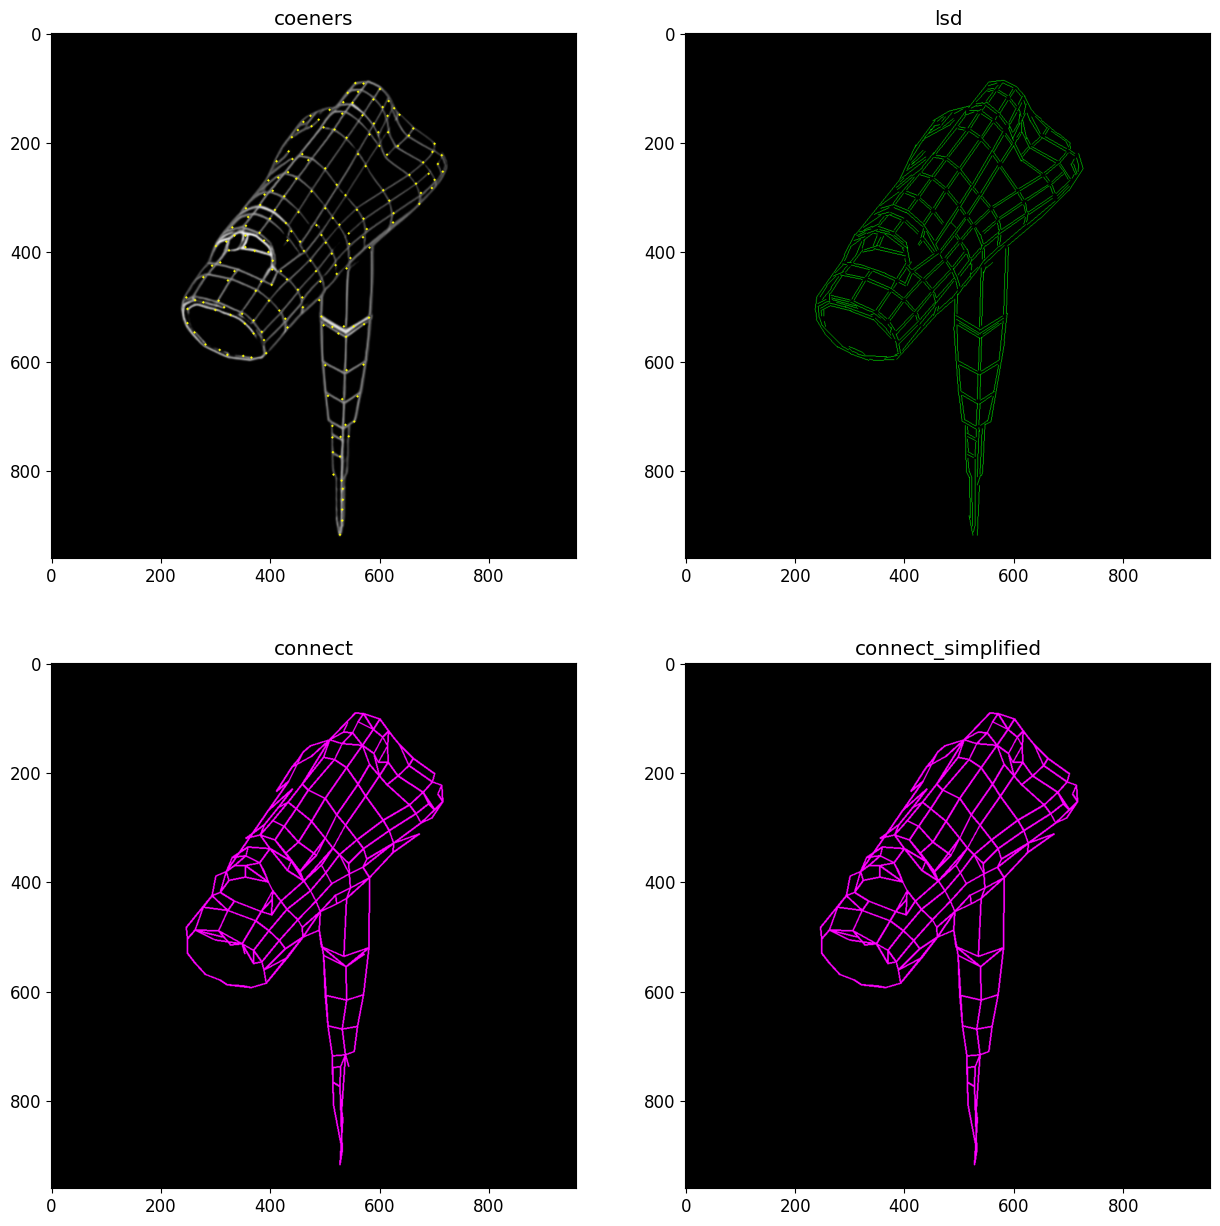

(174, 2)


In [4]:
#定义一些预先设置
plt.rcParams['figure.figsize'] = [15, 15]
save_dir = '928//hair//4file'  # 添加您的目录路径
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


img = cv2.imread('928//hair//4l.png')
img = cv2.resize(img, (960,960))
depth_img = cv2.imread('928//hair//4dp.png', cv2.IMREAD_GRAYSCALE)
depth_img = cv2.resize(depth_img, (960,960))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
p1,p2,p3,p4,p5,p6 = interactive_plot.result
corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
corners = np.intp(corners)
new_img = np.zeros_like(img)
new_img = img.copy()
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(new_img, (x, y), 2, (255,255,0), -1)  # 在角点位置绘制圆
plt.subplot(221),plt.imshow(new_img),plt.title('coeners')
cv2.imwrite(os.path.join(save_dir, 'corners.png'),new_img)#保存文件

corners=corners.reshape(-1,2)
print('corners number',len(corners),'corners shape',corners.shape)
'''
lines = cv2.HoughLinesP(gray, rho=1, theta=np.pi/180, threshold=50, minLineLength=10, maxLineGap=10)
blank_image=new_img.copy()
for line in lines.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.subplot(132),plt.imshow(blank_image)
'''
lsd = cv2.createLineSegmentDetector(1)
lines = lsd.detect(gray)[0]
print('lsd line number',len(lines),'lsd line shape',lines.shape)
#blank_image=new_img.copy()
blank_image=np.zeros_like(img)
for dline in lines:
    x0 = int(round(dline[0][0]))
    y0 = int(round(dline[0][1]))
    x1 = int(round(dline[0][2]))
    y1 = int(round(dline[0][3]))
    cv2.line(blank_image, (x0, y0), (x1,y1), (0, 255, 0), 1)
plt.subplot(222),plt.imshow(blank_image),plt.title('lsd')
cv2.imwrite(os.path.join(save_dir, 'lsd.png'),blank_image)#保存文件

connects=find_matching_corners_connection(lines.reshape(-1,2,2), corners, 20)
print('connects number',len(connects),'connects shape',connects.shape)
blank_image=np.zeros_like(img)
for line in connects.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (255, 0, 255), 2)
plt.subplot(223),plt.imshow(blank_image),plt.title('connect')
cv2.imwrite(os.path.join(save_dir, 'connect.png'),blank_image)#保存文件
connects = list(connects)
#链接简化
while True:
    # 把所有的点拉平并转换成元组
    points = [tuple(point) for line in connects for point in line]
    
    # 使用Counter来统计每个点出现的次数
    counter = Counter(points)

    # 找出只出现一次的点
    isolated_points = [point for point, count in counter.items() if count == 1]

    if len(isolated_points) == 0:
        break
    
    #构建新的connects，排除孤立的线段
    connects = [line for line in connects if tuple(line[0]) not in isolated_points and tuple(line[1]) not in isolated_points]

connects_new = np.array(connects)

connects_new = np.array(connects)
blank_image=np.zeros_like(img)
for line in connects_new.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(blank_image, (x1, y1), (x2, y2), (255, 0, 255), 2)
plt.subplot(224),plt.imshow(blank_image),plt.title('connect_simplified')
plt.show()
cv2.imwrite(os.path.join(save_dir, 'connect_new.png'),blank_image)#保存文件
#保存部分
connects=connects_new

# 初始化一个空集合用于存储所有的端点
corners = set()

# 遍历所有的线段
for line in connects:
    # 遍历线段的两个端点
    for point in line:
        # 将端点转换为不可变的元组，然后添加到集合中
        corners.add(tuple(point))

# 最后，如果你需要一个数组而不是一个集合，你可以将corners转换回数组
corners = np.array(list(corners))
print(corners.shape)
depth_values = depth_img[corners[:, 1], corners[:, 0]]
points_depth = np.column_stack((corners, depth_values))
points_depth = np.array(points_depth)
np.savetxt(os.path.join(save_dir, 'points_depth.txt'), points_depth, fmt='%d', delimiter=', ')
depth_values_start = depth_img[connects[:, 0, 1], connects[:, 0, 0]]
depth_values_end = depth_img[connects[:, 1, 1], connects[:, 1, 0]]
lines_depth_start = np.column_stack((connects[:, 0, :], depth_values_start))
lines_depth_end = np.column_stack((connects[:, 1, :], depth_values_end))
lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
with open(os.path.join(save_dir, 'lines_depth.txt'), 'w') as f:
    for line in lines_depth:
        f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(34078, 2, 2)


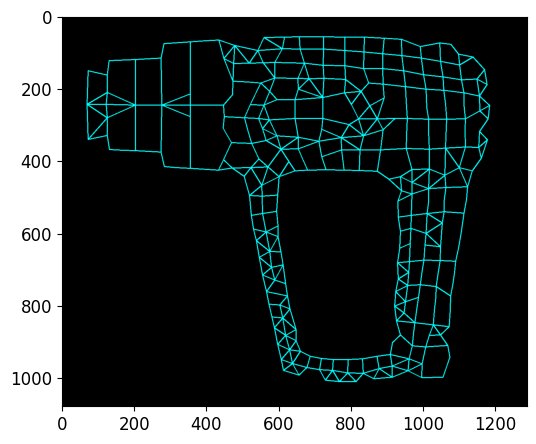

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(548, 2, 2)
(1036, 2, 2)


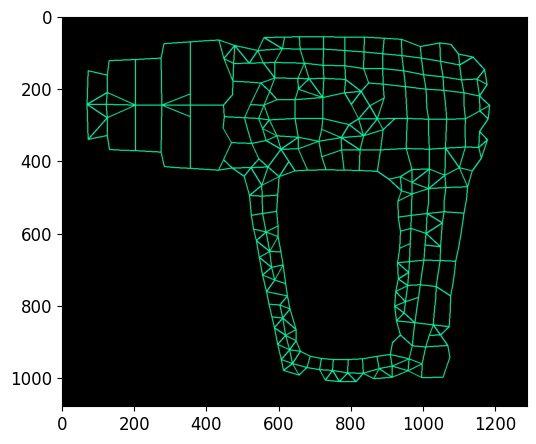

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


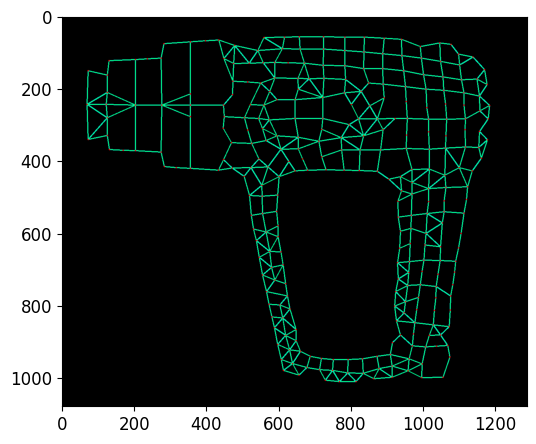

In [12]:
# 创建一个空的列表来存储连接线
connect_lines = []

# 遍历每一个白色像素点
for point in white_points:
    # 计算该点到corners中所有点的距离
    distances = np.sqrt(np.sum((corners - point)**2, axis=1))
    
    # 找到距离最近的两个点的索引
    closest_points_idx = np.argsort(distances)[:2]
    
    # 获取这两个点的坐标
    closest_points = corners[closest_points_idx]
    
    # 将这两个点的坐标添加到connect_lines
    connect_lines.append(closest_points)

# 将connect_lines转换为numpy数组
connect_lines = np.array(connect_lines)
print(connect_lines.shape)
# 去除重复的线段

new_img=np.zeros(img.shape)
for line in connect_lines.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 255), 2)
plt.imshow(new_img)
plt.show()
unique_lines=np.array(remove_duplicates(connect_lines))
unique_lines2=np.array(remove_duplicates2(connect_lines))
print(unique_lines.shape)
print(unique_lines2.shape)
#unique_lines = np.unique(np.sort(connect_lines, axis=1), axis=0)
for line in unique_lines.reshape(-1,4):
    x1, y1, x2, y2 = line
    cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(new_img)
plt.show()
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(new_img, (x, y), 2, (255,0,0), -1)  # 在角点位置绘制圆
plt.imshow(new_img)
plt.show()

In [6]:
def pic_corners_connections_detect_refer_white(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp):
    img = cv2.imread(pic_dir)
    cv2.imwrite(os.path.join(save_dir, 'source.png'),img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 找到所有亮度大于200的像素点
    white_points = np.where(gray > 50)
    # 新建一张和img大小一样的黑色图像
    new_img = np.zeros_like(img)
    # 在新图像上画出所有亮度大于200的像素点
    new_img[white_points] = 255

    # 使用plt展示新图像
    plt.imshow(new_img, cmap='gray')
    plt.show()
    p1,p2,p3,p4,p5,p6 = interactive_plot.result
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
    corners = np.intp(corners)
    # 统计并打印白色像素点的数量
    num_white_points = len(white_points[0])
    print("Number of white points: ", num_white_points)
    #new_img = np.zeros_like(img)
    for corner in corners:
        x, y = corner.ravel()  # 将角点坐标展平
        cv2.circle(new_img, (x, y), 5, (0,255,0), -1)  # 在角点位置绘制圆
    plt.imshow(new_img)
    plt.show()
    #从白色的点中去除一些以corner为圆心的圆
    for corner in corners:
        x, y = corner.ravel()  # 将角点坐标展平
        cv2.circle(new_img, (x, y), 6, (0,0,0), -1)  # 在角点位置绘制圆
    gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    # 找到所有新白色点
    white_points = np.where(gray == 255)
    num_white_points = len(white_points[0])
    print("Number of white points without corners: ", num_white_points)
    corners=corners.reshape(-1,2)
    white_points = np.transpose(white_points)
    white_points = np.fliplr(white_points)
    print(white_points.shape,corners.shape)    
    # 创建一个空的列表来存储连接线
    connect_lines = []   
    # 遍历每一个白色像素点
    for point in white_points:
        # 计算该点到corners中所有点的距离
        distances = np.sqrt(np.sum((corners - point)**2, axis=1))
        
        # 找到距离最近的两个点的索引
        closest_points_idx = np.argsort(distances)[:2]
        
        # 获取这两个点的坐标
        closest_points = corners[closest_points_idx]
        
        # 将这两个点的坐标添加到connect_lines
        connect_lines.append(closest_points)
    
    # 将connect_lines转换为numpy数组
    connect_lines = np.array(connect_lines)
    print(connect_lines.shape)
    # 去除重复的线段
    new_img=np.zeros(img.shape)
    for line in connect_lines.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 255), 2)
    plt.imshow(new_img)
    plt.show()
    unique_lines=np.array(remove_duplicates(connect_lines))
    print(unique_lines.shape)
    for line in unique_lines.reshape(-1,4):
        x1, y1, x2, y2 = line
        cv2.line(new_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    plt.imshow(new_img)
    plt.show()
    for corner in corners:
        x, y = corner.ravel()  # 将角点坐标展平
        cv2.circle(new_img, (x, y), 2, (255,0,0), -1)  # 在角点位置绘制圆
    plt.imshow(new_img)
    plt.show()

    cv2.imwrite(os.path.join(save_dir, 'line_web.png'),new_img) 

    #用凸包算法找到网格边界
    hull = ConvexHull(corners.reshape(-1,2))
    points = corners.reshape(-1,2)
    edges = []
    for simplex in hull.simplices:
        edge = points[simplex]
        edges.append(edge)
    edges = np.array(edges)
    corners = np.array(corners)
    corners = corners.reshape(-1,2)
    depth_img = cv2.imread(depth_dir, cv2.IMREAD_GRAYSCALE)
    lines3=unique_lines.reshape(-1,2,2)
    if depth_img is None:
        print('无法读取图片')
        print(depth_dir)
        sys.exit()
    depth_values = depth_img[corners[:, 1], corners[:, 0]]
    points_depth = np.column_stack((corners, depth_values))
    points_depth = np.array(points_depth)
    np.savetxt(os.path.join(save_dir, 'points_depth.txt'), points_depth, fmt='%d', delimiter=', ')
    depth_values_start = depth_img[lines3[:, 0, 1], lines3[:, 0, 0]]
    depth_values_end = depth_img[lines3[:, 1, 1], lines3[:, 1, 0]]
    lines_depth_start = np.column_stack((lines3[:, 0, :], depth_values_start))
    lines_depth_end = np.column_stack((lines3[:, 1, :], depth_values_end))
    lines_depth = np.stack((lines_depth_start, lines_depth_end), axis=1)
    with open(os.path.join(save_dir, 'lines_depth.txt'), 'w') as f:
        for line in lines_depth:
            f.write(','.join(map(str, line[0])) + ' ' + ','.join(map(str, line[1])) + '\n')
    depth_values_edges_start = depth_img[edges[:, 0, 1], edges[:, 0, 0]]
    depth_values_edges_end = depth_img[edges[:, 1, 1], edges[:, 1, 0]]
    edges_depth_start = np.column_stack((edges[:, 0, :], depth_values_edges_start))
    edges_depth_end = np.column_stack((edges[:, 1, :], depth_values_edges_end))
    edges_depth = np.stack((edges_depth_start, edges_depth_end), axis=1)
    with open(os.path.join(save_dir, 'edges_depth.txt'), 'w') as f:
        for edge in edges_depth:
            f.write(','.join(map(str, edge[0])) + ' ' + ','.join(map(str, edge[1])) + '\n')
    cv2.imwrite(os.path.join(save_dir, 'depth.png'),depth_img)

    print('检测到角点数目',len(corners),'最终连线数目',len(lines3))


def dir_corners_connections_detect(pics_dir, depths_dir, saves_dir, interactive_plot, interactive_hlpp):
    pics = os.listdir(pics_dir)
    for pic in pics:
        pic_name = os.path.splitext(pic)[0]
        pic_dir = os.path.join(pics_dir, pic)
        depth_dir = os.path.join(depths_dir, pic_name + '_depth'+'.png')
        save_dir = os.path.join(saves_dir, pic_name)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        pic_corners_connections_detect(pic_dir, depth_dir, save_dir, interactive_plot, interactive_hlpp)


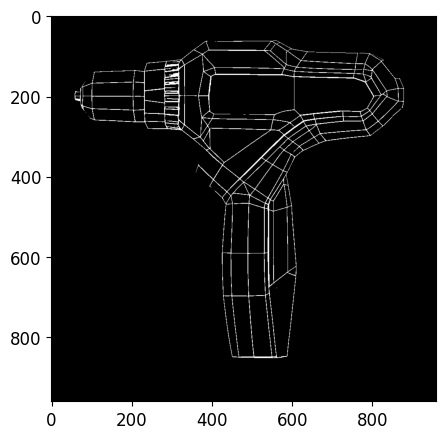

Number of white points:  25003


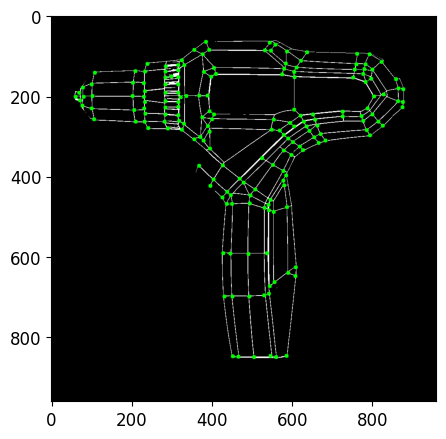

Number of white points without corners:  18541
(18541, 2) (185, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(18541, 2, 2)


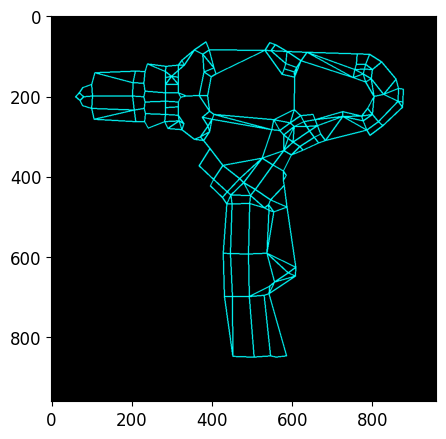

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(346, 2, 2)


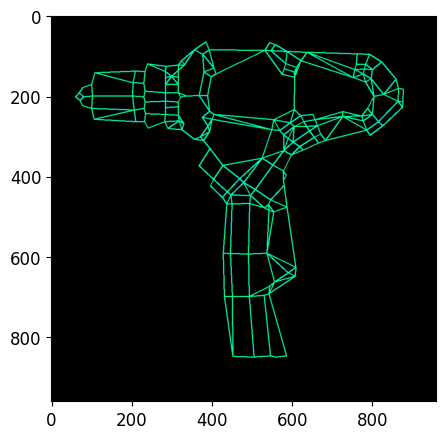

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


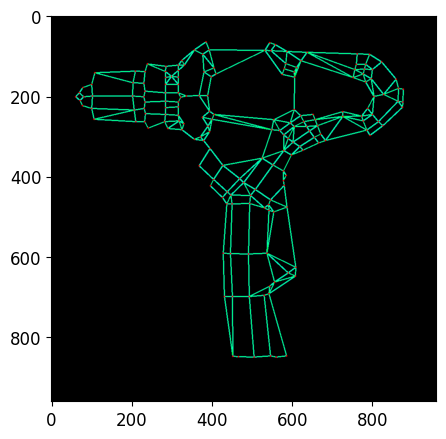

检测到角点数目 185 最终连线数目 346


In [18]:
pic_corners_connections_detect_refer_white('z1.png', 'z2.png', 'depth', interactive_plot, interactive_hlpp)

6


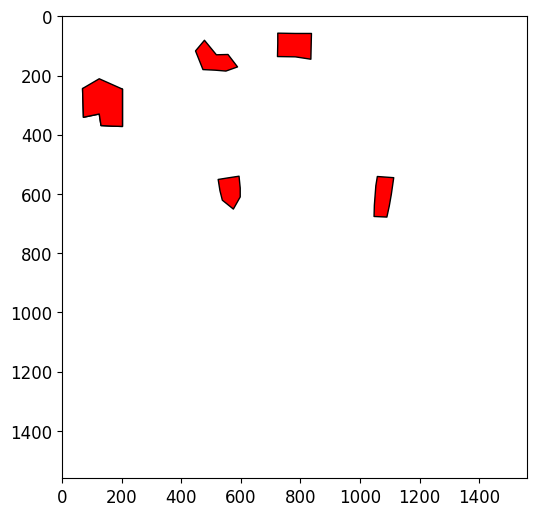

In [26]:
from networkx import Graph, cycle_basis, simple_cycles,minimum_cycle_basis
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
# 将所有线段的端点合并到一个列表中，并去重
points = corners.reshape(-1,2)

# 创建一个空的图
G = Graph()

# 将所有的点添加到图中
for point in points:
    G.add_node(tuple(point))

# 将所有的线段添加到图中
for line in unique_lines2:
    G.add_edge(tuple(line[0]), tuple(line[1]))

# 找到图中所有的环
cycles = cycle_basis(G)
# 筛选出一个范围内的多边形

polys= [cycle for cycle in cycles if len(cycle) == 8 ]
# 将结果转换为所需的格式
print(len(polys))
# 创建一个新的图形
fig, ax = plt.subplots()

# 创建一个空的列表来存储所有的多边形
patches = []

for poly in polys:
    polygon = Polygon(poly, closed=True)
    patches.append(polygon)

# 创建一个PatchCollection，设置为红色，并添加到图形中
p = PatchCollection(patches, color='red',edgecolor='black')
ax.add_collection(p)


# 设置坐标轴的范围
ax.set_xlim(0, 1560)
ax.set_ylim(0, 1560)
ax.invert_yaxis()
# 显示图形
plt.show()

In [15]:
polys= [cycle for cycle in cycles if len(cycle) == 4 ]
# 将结果转换为所需的格式
print(len(polys))

patches = []

for poly in polys:
    polygon = Polygon(poly, closed=True)
    patches.append(polygon)

# 创建一个PatchCollection，设置为红色，并添加到图形中
p = PatchCollection(patches, color='blue',edgecolor='black')
ax.add_collection(p)


# 设置坐标轴的范围
ax.set_xlim(0, 1560)
ax.set_ylim(0, 1560)
ax.invert_yaxis()
# 显示图形
plt.show()

43


In [ ]:
# backup

img = cv2.imread('z1.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 找到所有亮度大于200的像素点
white_points = np.where(gray > 50)

# 新建一张和img大小一样的黑色图像
new_img = np.zeros_like(img)

# 在新图像上画出所有亮度大于200的像素点
new_img[white_points] = 255

# 使用plt展示新图像
plt.imshow(new_img, cmap='gray')
plt.show()
# 统计并打印白色像素点的数量
num_white_points = len(white_points[0])
print("Number of white points: ", num_white_points)

corners = cv2.goodFeaturesToTrack(gray, maxCorners=p1, qualityLevel=p2, minDistance=p3, blockSize=int(p4), useHarrisDetector=p5, k=p6)
corners = np.intp(corners)
#new_img = np.zeros_like(img)
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(new_img, (x, y), 5, (0,255,0), -1)  # 在角点位置绘制圆
plt.imshow(new_img)
plt.show()
for corner in corners:
    x, y = corner.ravel()  # 将角点坐标展平
    cv2.circle(new_img, (x, y), 6, (0,0,0), -1)  # 在角点位置绘制圆
plt.imshow(new_img)
plt.show()

gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
# 找到所有亮度大于200的像素点

white_points = np.where(gray == 255)
num_white_points = len(white_points[0])
print("Number of white points: ", num_white_points)
corners=corners.reshape(-1,2)
white_points = np.transpose(white_points)
white_points = np.fliplr(white_points)
print(white_points.shape,corners.shape)